Look into initial results with CLASP+CLUBB_MF

In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable

from joblib import Parallel, delayed
import multiprocessing

warnings.filterwarnings('ignore')


## A few useful functions

In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [4]:
def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [5]:
def interpolateToPressure_v2_h3(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)
 
    ## Handle data that's by-plume *and* by subcycle for EDMF output
    elif np.shape(DS[varName].values)[2]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.ncyc.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            for iCyc in range(len(DS.ncyc.values)):
                varInterp[:,iCyc,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iCyc,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

            
    saveOut = varInterp
    
    return saveOut

In [6]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    # DS['TKE'].attrs['units']   = 'm2/s2'
    # DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )

    # DS['WindMagnitude'].attrs['units']   = 'm/s'
    # DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DS.P0.values/100        # mb 
#     hyam   = np.squeeze(DS.hyam.values)[:]
#     hybm   = np.squeeze(DS.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL','WindMagnitude','CONCLD','QT','GCLDLWP',
#                           'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
#                           'edmf_upbuoy','edmf_updet','edmf_upent',
#                           ## Add budget terms 
                          # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
                          # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                           'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                           'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                          'wpthlp','wprtp','rtp2',
                          # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
                          # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
                          # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
                          # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
                          # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
                          # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
                          # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                          ])

    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [7]:
def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                          'edmf_cloudfrac','edmf_dnw','edmf_precc',
                           ])
    
#     ## Get averages for ensembles that don't include zeros.... 
#     nTime = len(DS.time.values)

#     for iT in range(nTime):
#         selDS_h2 = scamDS_h2.isel(case=iCase, time=iT, lat=0, lon=0)

#         for iL in range(len(scamDS_h2.ilev.values)):
#             ivalPlumes = np.where( (selDS_h2.edmf_upthl.values!=0) &   # [ens,ilev]
#                                    (np.isfinite(selDS_h2.edmf_upthl.values)==True)
#                                    (selDS_h2.edmf_upa.values!=0) )[0]




    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [37]:
# Parallel loop over time 
def computeSumMacmic_parallel(recArray1, recArray2):
        
    total_var = np.full([len(recArray1.ilev.values)], np.nan)
    
    for iLev in range(len(recArray1.ilev.values)):
        part1 = recArray1.isel(ilev=iLev) 
        part2 = recArray2.isel(ilev=iLev)
        
        if ((np.isfinite(part1.values)==False) & (np.isfinite(part2.values)==False)):
            total_var[iLev] = np.nan
        else:
            total_var[iLev] = np.nansum([part1.values, part2.values])
    
    return total_var

In [35]:
# var1    = ['up_macmic1', 'dn_macmic1','upa_macmic1','dna_macmic1',
#            'thlu_macmic1','qtu_macmic1','thld_macmic1','qtd_macmic1']

# var2    = ['up_macmic2', 'dn_macmic2','upa_macmic2','dna_macmic2',
#            'thlu_macmic2','qtu_macmic2','thld_macmic2','qtd_macmic2']

# tic = time.perf_counter()

# iVar = 0
# selVar1 = caseH3[var1[iVar]].isel(lat=0,lon=0)
# selVar2 = caseH3[var2[iVar]].isel(lat=0,lon=0)
# iEns=0

# test =  Parallel(n_jobs=-1)(delayed(computeSumMacmic_parallel)(selVar1.isel(nens=iEns, time=i),
#                                                                           selVar2.isel(nens=iEns, time=i)) for i in range(len(caseH3.time.values)))
# toc = time.perf_counter()    
# print("Elapsed Time: %0.4f seconds" % (toc-tic))


Elapsed Time: 75.5493 seconds


In [40]:
np.shape(test)

(13320, 59)

In [36]:
# tic = time.perf_counter()
# DS = caseH3
# testVar = np.full([len(DS.time.values),len(DS.nens.values),len(DS.ilev.values),1,1], np.nan)

# # for iEns in range(len(DS.nens.values)):
# for iEns in range(1):
#     for iLev in range(len(DS.ilev.values)): 
#         for iT in range(len(DS.time.values)): 
            
#             selVar1 = caseH3[var1[iVar]].isel(lat=0,lon=0,time=iT,ilev=iLev,nens=iEns)
#             selVar2 = caseH3[var2[iVar]].isel(lat=0,lon=0,time=iT,ilev=iLev,nens=iEns)

#             if ((np.isfinite(selVar1.values)==False) & (np.isfinite(selVar2.values)==False)):
#                 testVar[iT,iEns,iLev,0,0] = np.nan
#             else:
#                 testVar[iT,iEns,iLev,0,0]= np.nansum([selVar1.values, selVar2.values])
                
# toc = time.perf_counter()    
# print("Elapsed Time: %0.4f seconds" % (toc-tic))


Elapsed Time: 404.2670 seconds


In [45]:
def process_camData_h3(DS, DSctrl):
    
        
    ## Combine across macmic subcycles 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    
    var1    = ['up_macmic1', 'dn_macmic1','upa_macmic1','dna_macmic1',
               'thlu_macmic1','qtu_macmic1','thld_macmic1','qtd_macmic1']

    var2    = ['up_macmic2', 'dn_macmic2','upa_macmic2','dna_macmic2',
               'thlu_macmic2','qtu_macmic2','thld_macmic2','qtd_macmic2']

    varSave = ['up_macmicAvg', 'dn_macmicAvg','upa_macmicAvg','dna_macmicAvg',
               'thlu_macmicAvg','qtu_macmicAvg','thld_macmicAvg','qtd_macmicAvg']

    for iVar in range(len(varSave)):
        selVar1 = DS[var1[iVar]].isel(lat=0,lon=0)
        selVar2 = DS[var2[iVar]].isel(lat=0,lon=0)
        
        totVar = np.full([len(DS.time.values),len(DS.nens.values),len(DS.ilev.values),1,1], np.nan)
        for iEns in range(len(DS.nens.values)):
            totVar[:,iEns,:,0,0] = Parallel(n_jobs=6)(delayed(computeSumMacmic_parallel)(selVar1.isel(nens=iEns, time=i),
                                                                              selVar2.isel(nens=iEns, time=i)) for i in range(len(DS.time.values)))

        print('done with getting macmic combination for var %s' % (varSave[iVar]))
        DS[varSave[iVar]] = (('time','nens','ilev','lat','lon'), totVar)
        
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                        #   'up_macmic1','up_macmic2','dn_macmic1','dn_macmic2',
                        # 'upa_macmic1','upa_macmic2','dna_macmic1','dna_macmic2',
                        # 'thlu_macmic1','thlu_macmic2','qtu_macmic1','qtu_macmic2',
                        # 'thld_macmic1','thld_macmic2','qtd_macmic1','qtd_macmic2',
                    'up_macmicAvg', 'dn_macmicAvg','upa_macmicAvg','dna_macmicAvg',
                   'thlu_macmicAvg','qtu_macmicAvg','thld_macmicAvg','qtd_macmicAvg'
                           ])
    
    for iVar in range(len(varSels)): 

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h3(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==6: 
            DS[varSels[iVar]+'_interp']  = (('time','ncyc','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [10]:
def preprocess_h0(ds):
    
#     keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
#                 'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
#                 ## Add budget terms 
#                 # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
#                 'wpthlp','wprtp',
#                 # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
#                 ]
    
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR','QT','GCLDLWP',
#                 'WPRTP2_CLUBB','WPTHLP2_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WPRTPTHLP_CLUBB',
#                 'WP2THLP_CLUBB','WPTHLP2_CLUBB','WPRTPTHLP_ZM_CLUBB',
#                 'WP4_CLUBB','WPRTP2_ZM_CLUBB','WPTHLP2_ZM_CLUBB','WP2RTP_ZM_CLUBB','WP2THLP_ZM_CLUBB',
                'THETAL','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
                'WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                # 'PRECZ',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT']
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel

In [11]:
def preprocess_h1(ds):
    
    keepVars = [
#                 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                'wpthlp','wprtp','rtp2',
                'thlm','rtm',
#                 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                ]
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel

In [12]:
def preprocess_h2(ds):
    
    varSels = np.asarray([
                      'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel

In [13]:
def preprocess_h3(ds):

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['thlu_macmic2'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel

In [14]:
## Pre-processing to get CLM data

def preprocessCLM_h0(ds):
    
    keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA',
                    'QVEGT','QVEGE','QSOIL','H2OSOI','TSOI','SOILLIQ']

    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars_CLM]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
    dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    
    return dsSel



In [15]:
## Pre-processing to get CLM data

def preprocessCLM_h1(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
    dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean()
    
    return dsSel


For plotting

In [16]:
def getStatSigCI(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0            
            
            
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

In [17]:
def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI_h2.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI_h2.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI_h2.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI_h2.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

In [18]:
def getMaxValHeightTime(DS,varName, maxLev,levName,timeName):
    iMax = np.where(DS[levName].values>=maxLev)[0]
    DS   = DS.isel(levInterp=iMax.astype(int))
    
    maxValTemp = np.nanmax(np.squeeze(DS[varName].values))
    minValTemp = np.nanmin(np.squeeze(DS[varName].values))
    
    if np.abs(maxValTemp)>np.abs(minValTemp):
        maxVal = maxValTemp
    elif np.abs(maxValTemp)<np.abs(minValTemp):
        maxVal = minValTemp
    else: 
        maxVal = maxValTemp
        
    iMax = np.where(DS[varName].values == maxVal)
    hgtMax = DS[levName].values[iMax[1]]
    timeMax = DS[timeName].values[iMax[0]]
    
    return maxVal, hgtMax, timeMax

## Read in data

**Single column CAM and CLM data**

In [46]:
# archiveDir  = '/scratch/cluster/mdfowler/tempOutput_claspMF/'
testDir     = '/glade/work/mdfowler/CLASP/CLUBB_MF/SCAM_histFiles/clmInit/'

case_names  = [
               'clubbMF',
               'clasp+MF',
#                'clubbMF_setSfcFlux',
#                'claspMF_setSfcFlux'
              ]

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

caseStrings = [
#                'usePatchDataFALSE_setSfcFlxFALSE_fixEvap_noFlxAvg_ZMoff_addMFflags',
#                'usePatchDataTRUE_setSfcFlxFALSE_fixEvap_noFlxAvg_ZMoff_addMFflags',
    
                'usePatchDataFALSE_setSfcFlxFALSE_mfMergeFeb_clmInit',
                'usePatchDataTRUE_setSfcFlxFALSE_mfMergeFeb_clmInit',
    
#                'usePatchDataFALSE_setSfcFlxTRUE_fixEvap_noFlxAvg_ZMoff_addMFflags',
#                'usePatchDataTRUE_setSfcFlxTRUE_fixEvap_noFlxAvg_ZMoff_addMFflags',
              ]

for iCase in range(len(case_names)):
    print('*** Starting on case %s ***' % (case_names[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h0*'))
    listFiles_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h1*'))
    listFiles_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h2*'))
    listFiles_h3 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h3*'))

    listFilesCLM_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h1*'))
    listFilesCLM_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h0*'))        

    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h0 files loaded')
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h1 files loaded')
    case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 files loaded with mfdataset')
    
    case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h3 files loaded with mfdataset')
        
     # Merge cases and load
    caseFull = xr.merge([case_h1, case_h0])
    caseFull = caseFull.assign_coords({"nens": np.arange(10)})
    caseH2  = case_h2.assign_coords({"nens": np.arange(10)})
    caseH3  = case_h3.assign_coords({"nens": np.arange(10)})
    caseH3 = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})

    print('DS merged and loaded')
    
    ## Process data 
    procDS    = process_camData( caseFull )
    procDS_h2 = process_camData_h2( caseH2, procDS  )
    procDS_h3 = process_camData_h3( caseH3, procDS  )

            
    ## Combine all the cases into 
    case_allDays      = procDS.assign_coords({"case":  case_names[iCase]})
    h2_allDays        = procDS_h2.assign_coords({"case":  case_names[iCase]})
    h3_allDays        = procDS_h3.assign_coords({"case":  case_names[iCase]})

                        
    if iCase==0:
        scamDS    = case_allDays
        scamDS_h2 = h2_allDays
        scamDS_h3 = h3_allDays
    else: 
        scamDS    = xr.concat([scamDS, case_allDays], "case") 
        scamDS_h2 = xr.concat([scamDS_h2, h2_allDays], "case") 
        scamDS_h3 = xr.concat([scamDS_h3, h3_allDays], "case") 

            
    ## Read in CLM datasets too 
 
    caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0,  preprocess=preprocessCLM_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h0 files loaded with mfdataset')

    caseCLM_h1 = xr.open_mfdataset(listFilesCLM_h1,  preprocess=preprocessCLM_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h1 files loaded with mfdataset')

    caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
    caseCLMh1_allDays = caseCLM_h1.assign_coords({"case":  case_names[iCase]})

    if iCase==0:
        clmDS_h0 = caseCLMh0_allDays
        clmDS_h1 = caseCLMh1_allDays
    else: 
        clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
        clmDS_h1 = xr.concat([clmDS_h1, caseCLMh1_allDays], "case") 
    print('Done with CLM h0 files')
            
    print('Done with case %i of %i ' % (iCase+1, len(case_names)))
    

*** Starting on case clubbMF ***
h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginning interpolation...
done with getting macmic combination for var up_macmicAvg
done with getting macmic combination for var dn_macmicAvg
done with getting macmic combination for var upa_macmicAvg
done with getting macmic combination for var dna_macmicAvg
done with getting macmic combination for var thlu_macmicAvg
done with getting macmic combination for var qtu_macmicAvg
done with getting macmic combination for var thld_macmicAvg
done with getting macmic combination for var qtd_macmicAvg
Beginning interpolation...
CLM_h0 files loaded with mfdataset
CLM_h1 files loaded with mfdataset
Done with CLM h0 files
Done with case 1 of 2 
*** Starting on case clasp+MF ***
h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginni

KeyboardInterrupt: 

### Get the contribution of MF that can be added to CLUBB's moments

In [39]:
# Parallel loop over time 
def computeSum_parallel(recArrayCLUBB, recArrayMF, clubbMult, i):
    
#     if np.remainder(i,10)==0:
#         print('Now on time...', i) 
        
    total_var = np.full([len(recArrayCLUBB.levInterp.values)], np.nan)
    
    for iLev in range(len(recArrayCLUBB.levInterp.values)):
        clubbPart = recArrayCLUBB.isel(levInterp=iLev) * clubbMult
        mfPart    = recArrayMF.isel(levInterp=iLev)
        
        total_var[iLev] = np.nansum([clubbPart.values, mfPart.values])
    
    return total_var

In [99]:
testDS = scamDS_h2.edmf_upw_interp.isel(levInterp=-5, lat=0, lon=0, case=1)

for iT in range(len(testDS.time.values)):
    sumPlumes = np.sum(np.isfinite(testDS.isel(time=iT).values))
    if (sumPlumes>0) & (sumPlumes<10):
        print('iT: ',iT, '    NumPlumes: ',sumPlumes)
    


iT:  43     NumPlumes:  1
iT:  45     NumPlumes:  1
iT:  46     NumPlumes:  2
iT:  47     NumPlumes:  2
iT:  48     NumPlumes:  5
iT:  49     NumPlumes:  5
iT:  50     NumPlumes:  7
iT:  51     NumPlumes:  8
iT:  52     NumPlumes:  8
iT:  219     NumPlumes:  1
iT:  220     NumPlumes:  1
iT:  221     NumPlumes:  1
iT:  222     NumPlumes:  1
iT:  223     NumPlumes:  7
iT:  224     NumPlumes:  8
iT:  225     NumPlumes:  8
iT:  238     NumPlumes:  9
iT:  397     NumPlumes:  2
iT:  398     NumPlumes:  4
iT:  399     NumPlumes:  5
iT:  400     NumPlumes:  5
iT:  409     NumPlumes:  9
iT:  505     NumPlumes:  9
iT:  579     NumPlumes:  3
iT:  580     NumPlumes:  3
iT:  581     NumPlumes:  7
iT:  582     NumPlumes:  9
iT:  583     NumPlumes:  8
iT:  586     NumPlumes:  9
iT:  590     NumPlumes:  9
iT:  598     NumPlumes:  9
iT:  622     NumPlumes:  9
iT:  623     NumPlumes:  9
iT:  778     NumPlumes:  1
iT:  779     NumPlumes:  1
iT:  780     NumPlumes:  1
iT:  781     NumPlumes:  1
iT:  782  

In [104]:
np.nanmean(testDS.isel(time=52).values)

1.9799399583865058

In [103]:
edmf_meanUPW.isel(time=52, levInterp=-5, case=1, lat=0,lon=0).values

array(1.97993996)

In [40]:
edmf_wp2 = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
                     len(scamDS_h2.levInterp.values), 
                     len(scamDS_h2.lat.values), len(scamDS_h2.lon.values)])

edmf_wpthlp = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
                        len(scamDS_h2.levInterp.values), 
                        len(scamDS_h2.lat.values), len(scamDS_h2.lon.values)])

edmf_wprtp = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
                       len(scamDS_h2.levInterp.values), 
                       len(scamDS_h2.lat.values), len(scamDS_h2.lon.values)])

edmf_thlp2 = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
                       len(scamDS_h2.levInterp.values), 
                       len(scamDS_h2.lat.values), len(scamDS_h2.lon.values)])

edmf_rtp2 = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
                      len(scamDS_h2.levInterp.values), 
                      len(scamDS_h2.lat.values), len(scamDS_h2.lon.values)])

edmf_meanUPW   = scamDS_h2.edmf_upw_interp.mean(dim='nens')    # m/s
edmf_meanUPTHL = scamDS_h2.edmf_upthl_interp.mean(dim='nens')  # K
edmf_meanUPRT  = scamDS_h2.edmf_upqt_interp.mean(dim='nens')   #kg/kg


for iEns in range(len(scamDS_h2.nens.values)):
    selEns   = scamDS_h2.isel(nens = iEns)
    
    edmf_wp2 = edmf_wp2 + (selEns.edmf_upa_interp.values * ((selEns.edmf_upw_interp.values - edmf_meanUPW)**2))
#     edmf_wp2 = edmf_wp2 + (selEns.edmf_upa_interp.values * ((selEns.edmf_upw_interp.values - scamDS.OMEGA_interp.values)**2))

    
    edmf_wpthlp = edmf_wpthlp + (selEns.edmf_upa_interp.values * 
                                 ((selEns.edmf_upw_interp.values - edmf_meanUPW)*(selEns.edmf_upthl_interp.values - edmf_meanUPTHL)) )

    edmf_wprtp = edmf_wprtp + (selEns.edmf_upa_interp.values * 
                                 ((selEns.edmf_upw_interp.values - edmf_meanUPW)*(selEns.edmf_upqt_interp.values - edmf_meanUPRT)) )

    edmf_thlp2 = edmf_thlp2 + (selEns.edmf_upa_interp.values * 
                                 ((selEns.edmf_upthl_interp.values - edmf_meanUPTHL)*(selEns.edmf_upthl_interp.values - edmf_meanUPTHL)) )

    edmf_rtp2  = edmf_rtp2 + (selEns.edmf_upa_interp.values * 
                                 ((selEns.edmf_upqt_interp.values - edmf_meanUPRT)*(selEns.edmf_upqt_interp.values - edmf_meanUPRT)) )

    
scamDS_h2['edmf_wp2']  = (('case','time','levInterp','lat','lon'), edmf_wp2) 
# scamDS_h2['total_wp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wp2, 
#                                                                               scamDS['WP2_CLUBB_interp'].values], axis=1)) 

    
scamDS_h2['edmf_wpthlp']  = (('case','time','levInterp','lat','lon'), edmf_wpthlp) 
# scamDS_h2['total_wpthlp_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wpthlp,
#                                                                                  scamDS['wpthlp_interp'].values], axis=1)) 

scamDS_h2['edmf_wprtp']  = (('case','time','levInterp','lat','lon'), edmf_wprtp) 
# scamDS_h2['total_wprtp_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wprtp,
#                                                                                 scamDS['wprtp_interp'].values], axis=1)) 

scamDS_h2['edmf_thlp2']  = (('case','time','levInterp','lat','lon'), edmf_thlp2) 
# scamDS_h2['total_thlp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_thlp2,
#                                                                                 scamDS['THLP2_CLUBB_interp'].values], axis=1)) 

scamDS_h2['edmf_rtp2']  = (('case','time','levInterp','lat','lon'), edmf_rtp2) 
# scamDS_h2['total_rtp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_rtp2,
#                                                                                (1e-6*scamDS['RTP2_CLUBB_interp'].values)], axis=1)) 
# #                                                                                (scamDS['rtp2_interp'].values)], axis=1)) 

# NOTE: need to convert CLUBB_rtp2 to kg2/kg2 (from g2/kg2) when summing


## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
## Make sure the additions are working properly 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

nTimes = len(scamDS.time.values)

iCase_clubb = np.where(scamDS.case.values=='clubbMF')
iCase_clasp = np.where(scamDS.case.values=='clasp+MF')

# ------ WP2 ------
clubbVar = 'WP2_CLUBB_interp'
mfVar    = 'edmf_wp2'

total_wp2 = np.full([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
                      len(scamDS_h2.levInterp.values), 
                      len(scamDS_h2.lat.values), len(scamDS_h2.lon.values)], np.nan)

total_wp2[iCase_clubb,:,:,0,0] = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
                                                                    scamDS_h2[mfVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
                                                                    1, i) 
                                       for i in range(nTimes))

total_wp2[iCase_clasp,:,:,0,0] = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
                                                                    scamDS_h2[mfVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
                                                                    1, i) 
                                       for i in range(nTimes))

# total_wp2[iCase_clubb,:,:,0,0]  = total_wp2_clubbMF
# total_wp2[iCase_clasp,:,:,0,0]  = total_wp2_claspMF
scamDS_h2['total_wp2'] = (('case','time','levInterp','lat','lon'), total_wp2) 
print('** Done computing total wp2 **')
                          
# ------ WPTHLP ------
clubbVar = 'wpthlp_interp'
mfVar    = 'edmf_wpthlp'

total_wpthlp = np.full([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
                      len(scamDS_h2.levInterp.values), 
                      len(scamDS_h2.lat.values), len(scamDS_h2.lon.values)], np.nan)

total_wpthlp[iCase_clubb,:,:,0,0]  = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
                                                                    scamDS_h2[mfVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
                                                                    1, i) 
                                       for i in range(nTimes))

total_wpthlp[iCase_clasp,:,:,0,0]  = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
                                                                    scamDS_h2[mfVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
                                                                    1, i) 
                                       for i in range(nTimes))

scamDS_h2['total_wpthlp'] = (('case','time','levInterp','lat','lon'), total_wpthlp) 
print('** Done computing total wpthlp **')


# ------ WPRTP ------
clubbVar = 'wprtp_interp'
mfVar    = 'edmf_wprtp'

total_wprtp = np.full([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
                      len(scamDS_h2.levInterp.values), 
                      len(scamDS_h2.lat.values), len(scamDS_h2.lon.values)], np.nan)

total_wprtp[iCase_clubb,:,:,0,0]  = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
                                                                    scamDS_h2[mfVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
                                                                    1, i) 
                                       for i in range(nTimes))

total_wprtp[iCase_clasp,:,:,0,0]  = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
                                                                    scamDS_h2[mfVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
                                                                    1, i) 
                                       for i in range(nTimes))

scamDS_h2['total_wprtp'] = (('case','time','levInterp','lat','lon'), total_wprtp) 
print('** Done computing total wprtp **')


# ------ THLP2 ------
clubbVar = 'THLP2_CLUBB_interp'
mfVar    = 'edmf_thlp2'

total_thlp2 = np.full([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
                      len(scamDS_h2.levInterp.values), 
                      len(scamDS_h2.lat.values), len(scamDS_h2.lon.values)], np.nan)

total_thlp2[iCase_clubb,:,:,0,0]  = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
                                                                    scamDS_h2[mfVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
                                                                    1, i) 
                                       for i in range(nTimes))

total_thlp2[iCase_clasp,:,:,0,0]  = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
                                                                    scamDS_h2[mfVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
                                                                    1, i) 
                                       for i in range(nTimes))

scamDS_h2['total_thlp2'] = (('case','time','levInterp','lat','lon'), total_thlp2) 
print('** Done computing total thlp2 **')


# ------ RTP2 ------
clubbVar = 'RTP2_CLUBB_interp'
mfVar    = 'edmf_rtp2'

total_rtp2 = np.full([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
                      len(scamDS_h2.levInterp.values), 
                      len(scamDS_h2.lat.values), len(scamDS_h2.lon.values)], np.nan)

total_rtp2[iCase_clubb,:,:,0,0]  = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
                                                                    scamDS_h2[mfVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
                                                                    1e-6, i) 
                                       for i in range(nTimes))

total_rtp2[iCase_clasp,:,:,0,0]  = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
                                                                    scamDS_h2[mfVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
                                                                    1e-6, i) 
                                       for i in range(nTimes))

scamDS_h2['total_rtp2'] = (('case','time','levInterp','lat','lon'), total_rtp2) 
print('** Done computing total rtp2 **')


KeyboardInterrupt: 

In [74]:
scamDS_h2['total_wp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wp2, 
                                                                              scamDS['WP2_CLUBB_interp'].values], axis=1)) 
scamDS_h2['total_wpthlp_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wpthlp,
                                                                                 scamDS['wpthlp_interp'].values], axis=1)) 
scamDS_h2['total_wprtp_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wprtp,
                                                                                scamDS['wprtp_interp'].values], axis=1)) 
scamDS_h2['total_thlp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_thlp2,
                                                                                scamDS['THLP2_CLUBB_interp'].values], axis=1)) 
scamDS_h2['total_rtp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_rtp2,
                                                                               (1e-6*scamDS['RTP2_CLUBB_interp'].values)], axis=1)) 


In [77]:
# nTimes = len(scamDS.time.values)

# clubbVar = 'WP2_CLUBB_interp'
# mfVar    = 'edmf_wp2'

# total_wp2_clubbMF = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
#                                                                     scamDS_h2[mfVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
#                                                                     1, i) 
#                                        for i in range(nTimes))

# total_wp2_claspMF = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
#                                                                     scamDS_h2[mfVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
#                                                                     1, i) 
#                                        for i in range(nTimes))

# selCase = 'clasp+MF'
selCase = 'clubbMF'
testDS       = scamDS_h2.sel(case=selCase).isel(lat=0,lon=0,levInterp=-3)
testDS_clubb = scamDS['WP2_CLUBB_interp'].sel(case=selCase).isel(lat=0,lon=0,levInterp=-3)

for iT in range(100):
    clubbPart  = testDS_clubb.values[iT]
    mfPart     = testDS['edmf_wp2'].values[iT]
#     sumParts   = np.nansum([clubbPart, mfPart])
    sumParts   = clubbPart+mfPart
    totalSaved = testDS['total_wp2'].values[iT]
    
    if sumParts==totalSaved: 
        print('Cool, no issues with iTime ', iT)
        print('    clubbPart = %.4f' % (clubbPart))
        print('    mfPart    = %.4f' % (mfPart))
        print('    sumBoth   = %.4f' % (sumParts))
        print('    totSaved  = %.4f' % (totalSaved))
        print('    totSaved_old  = %.4f' % (testDS['total_wp2_old'].values[iT]))
        print('    Potential hack fix = %.4f' % (total_wp2_claspMF[iT][-3]) )
    else:
        print('ERROR Will Robinson: iTime = ', iT)
        print('    clubbPart = %.4f' % (clubbPart))
        print('    mfPart    = %.4f' % (mfPart))
        print('    sumBoth   = %.4f' % (sumParts))
        print('    totSaved  = %.4f' % (totalSaved))
        print('    totSaved_old  = %.4f' % (testDS['total_wp2_old'].values[iT]))
        print('    Potential hack fix = %.4f' % (total_wp2_claspMF[iT][-3]) )
        

ERROR Will Robinson: iTime =  0
    clubbPart = 0.0014
    mfPart    = nan
    sumBoth   = nan
    totSaved  = 0.0014
    totSaved_old  = 0.0000
    Potential hack fix = 0.0014
ERROR Will Robinson: iTime =  1
    clubbPart = 0.0014
    mfPart    = nan
    sumBoth   = nan
    totSaved  = 0.0014
    totSaved_old  = 0.0000
    Potential hack fix = 0.0014
ERROR Will Robinson: iTime =  2
    clubbPart = 0.0014
    mfPart    = nan
    sumBoth   = nan
    totSaved  = 0.0014
    totSaved_old  = 0.0000
    Potential hack fix = 0.0014
ERROR Will Robinson: iTime =  3
    clubbPart = 0.0014
    mfPart    = nan
    sumBoth   = nan
    totSaved  = 0.0014
    totSaved_old  = 0.0000
    Potential hack fix = 0.0014
ERROR Will Robinson: iTime =  4
    clubbPart = 0.0014
    mfPart    = nan
    sumBoth   = nan
    totSaved  = 0.0014
    totSaved_old  = 0.0000
    Potential hack fix = 0.0014
ERROR Will Robinson: iTime =  5
    clubbPart = 0.0014
    mfPart    = nan
    sumBoth   = nan
    totSaved  = 0.00

Text(0.5, 0, 'K^2')

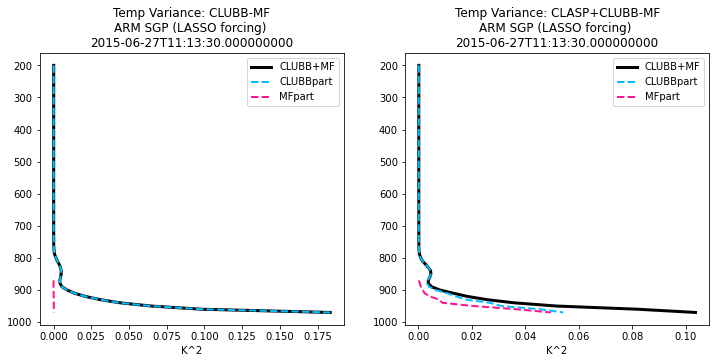

In [28]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

totVar   = 'total_thlp2'
clubbVar = 'THLP2_CLUBB_interp'
mfVar    = 'edmf_thlp2'
unitsStr = 'K^2'
varName  = 'Temp Variance'

selTime  = 410

colorsel = ['black','deepskyblue','deeppink']
linestylesel = ['-','--','--']
linewidthsel = [3,2,2]



axs[0].plot(scamDS_h2[totVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0], 
            label='CLUBB+MF')
axs[0].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[0].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[1].plot(scamDS_h2.total_thlp2.isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0],
            label='CLUBB+MF')
axs[1].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
             scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[1].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
             scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varName+': CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[0].set_xlabel(unitsStr)


axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varName+': CLASP+CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[1].set_xlabel(unitsStr)



Text(0.5, 0, 'm^2 s^-2')

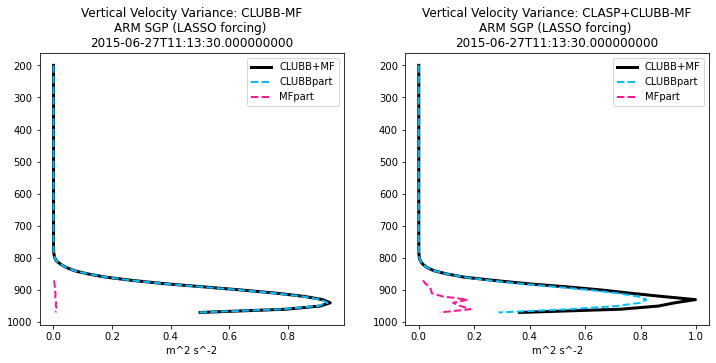

In [29]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

totVar   = 'total_wp2'
clubbVar = 'WP2_CLUBB_interp'
mfVar    = 'edmf_wp2'
unitsStr = 'm^2 s^-2'
varName  = 'Vertical Velocity Variance'

selTime  = 410

colorsel = ['black','deepskyblue','deeppink']
linestylesel = ['-','--','--']
linewidthsel = [3,2,2]



axs[0].plot(scamDS_h2[totVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0], 
            label='CLUBB+MF')
axs[0].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[0].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[1].plot(scamDS_h2[totVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0],
            label='CLUBB+MF')
axs[1].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
             scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[1].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
             scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varName+': CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[0].set_xlabel(unitsStr)


axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varName+': CLASP+CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[1].set_xlabel(unitsStr)


Text(0.5, 0, 'K m/s')

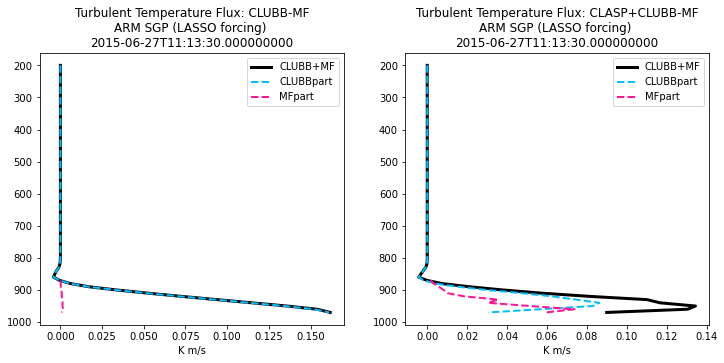

In [30]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

totVar   = 'total_wpthlp'
clubbVar = 'wpthlp_interp'
mfVar    = 'edmf_wpthlp'
unitsStr = 'K m/s'
varName  = 'Turbulent Temperature Flux'

selTime  = 410

colorsel = ['black','deepskyblue','deeppink']
linestylesel = ['-','--','--']
linewidthsel = [3,2,2]



axs[0].plot(scamDS_h2[totVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0], 
            label='CLUBB+MF')
axs[0].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[0].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[1].plot(scamDS_h2[totVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0],
            label='CLUBB+MF')
axs[1].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
             scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[1].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
             scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varName+': CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[0].set_xlabel(unitsStr)


axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varName+': CLASP+CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[1].set_xlabel(unitsStr)



Text(0.5, 0, 'kg/kg m/s')

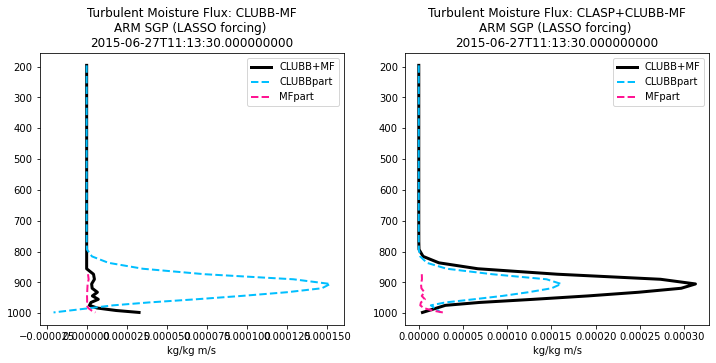

In [20]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

totVar   = 'total_wprtp'
clubbVar = 'wprtp_interp'
mfVar    = 'edmf_wprtp'
unitsStr = 'kg/kg m/s'
varName  = 'Turbulent Moisture Flux'

selTime  = 410

colorsel = ['black','deepskyblue','deeppink']
linestylesel = ['-','--','--']
linewidthsel = [3,2,2]



axs[0].plot(scamDS_h2[totVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0], 
            label='CLUBB+MF')
axs[0].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[0].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[1].plot(scamDS_h2[totVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0],
            label='CLUBB+MF')
axs[1].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
             scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[1].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF'), 
             scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varName+': CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[0].set_xlabel(unitsStr)


axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varName+': CLASP+CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[1].set_xlabel(unitsStr)




In [67]:
random_iT = 968
random_ilev = -2

selCase  = 'clubbMF'

# totVar   = 'total_wprtp'
# clubbVar = 'wprtp_interp'
# mfVar    = 'edmf_wprtp'

# totVar   = 'total_wpthlp'
# clubbVar = 'wpthlp_interp'
# mfVar    = 'edmf_wpthlp'

totVar   = 'total_thlp2'
clubbVar = 'THLP2_CLUBB_interp'
mfVar    = 'edmf_thlp2'


print('Snapshot values at time %s and level %.2f' % (scamDS.time.values[random_iT], 
                                                     scamDS.levInterp.values[random_ilev]) )
print('%19s = %12.3f\n%19s = %12.3f\n%19s = %12.3f' % (clubbVar,
                                                       scamDS[clubbVar].isel(time=random_iT,levInterp=random_ilev,
                                                                              lon=0,lat=0).sel(case=selCase),
                                                       mfVar, 
                                                       scamDS_h2[mfVar].isel(time=random_iT,levInterp=random_ilev,
                                                                              lon=0,lat=0).sel(case=selCase),
                                                       totVar,
                                                       scamDS_h2[totVar].isel(time=random_iT,levInterp=random_ilev,
                                                                              lon=0,lat=0).sel(case=selCase) ) )


Snapshot values at time 2016-05-18T12:43:30.000000000 and level 960.00
 THLP2_CLUBB_interp =        0.075
         edmf_thlp2 =        0.001
        total_thlp2 =        0.076


## Plots and Analysis 

### PDFs

In [22]:
scamRain  = scamDS.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,

# SCAM
rainRatesHMG_scam = scamRain.sel(case='clubbMF').values
rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

rainRatesHTG_scam = scamRain.sel(case='clasp+MF').values
rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHTG_scam>0)[0]]


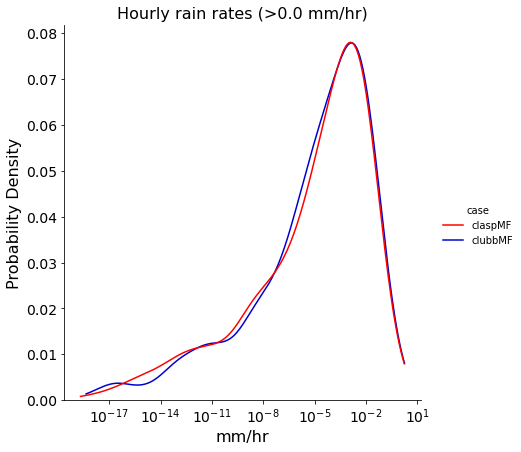

In [23]:
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG_scam), 'case': 'claspMF'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG_scam), 'case': 'clubbMF'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=6, cut=0, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['red','mediumblue'], legend=True)

# g.ax.set_xlim([10**-13, 10**1])
g.ax.set_title("Hourly rain rates (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
# plt.setp(g._legend.get_title(), fontsize=14)
# plt.setp(g._legend.get_texts(), fontsize=14)
# plt.setp(g.ax.lines[5], linestyle='--')   # Index goes in reverse order 
# plt.legend(loc='upper left', 
#            labels=['Obs','LES_HMG','LES_HTG','SCAM_HMG','SCAM_HTG',r"SCAM_HTG$_\alpha$",r"SCAM_HTG$_{100}$"], 
#            ncol=2, fontsize=12)




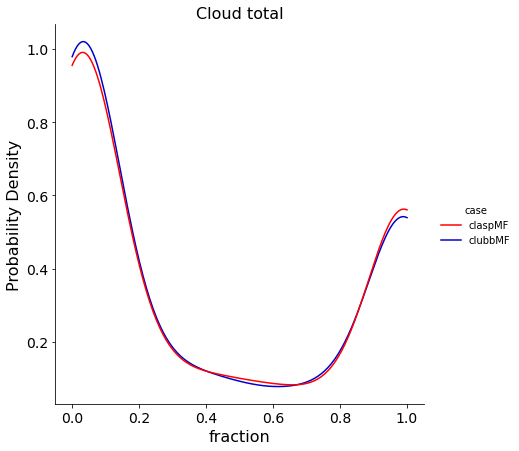

In [29]:
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')

scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')
# Limit to daytime hours
selHours = np.where(scamCLD['time.hour'].values<=19)[0]
scamCLD  = scamCLD.isel(time=selHours)

# SCAM
cldHMG_scam = scamCLD.sel(case='clubbMF').values
cldHTG_scam = scamCLD.sel(case='clasp+MF').values

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHTG_scam), 'case': 'claspMF'}),
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHMG_scam), 'case': 'clubbMF'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Cloud Fraction', hue='case', kind='kde', height=6, cut=0,
                palette=['red','mediumblue'])

g.ax.set_title("Cloud total", fontsize=16 ) 
g.ax.set_xlabel('Cloud fraction',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)

plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=12)


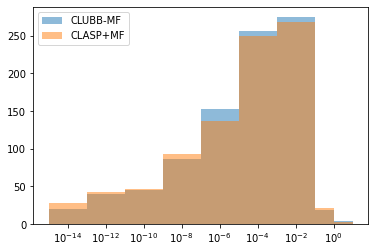

In [25]:
binEdges = [10e-16, 10e-14, 10e-12, 10e-10, 10e-8, 10e-6, 10e-4, 10e-2, 10e-1,10]

plt.hist(np.squeeze(rainRatesHMG_scam),alpha = 0.5, bins=binEdges)
plt.hist(np.squeeze(rainRatesHTG_scam), alpha=0.5, bins=binEdges)

plt.xscale('log')
plt.legend(['CLUBB-MF', 'CLASP+MF'])


In [35]:
upthl_clubbMF = scamDS_h2.edmf_upthl_interp.isel(lat=0,lon=0).sel(case='clubbMF')
upthl_claspMF = scamDS_h2.edmf_upthl_interp.isel(lat=0,lon=0).sel(case='clasp+MF')

countValPlumes_clubb = np.zeros([len(upthl_clubbMF.levInterp.values)])
countValPlumes_clasp = np.zeros([len(upthl_clubbMF.levInterp.values)])

for iLev in range(len(upthl_clubbMF.levInterp.values)):
    countValPlumes_clubb[iLev] = np.shape(np.where( np.isfinite(upthl_clubbMF.isel(levInterp=iLev))==True))[1]
    countValPlumes_clasp[iLev] = np.shape(np.where( np.isfinite(upthl_claspMF.isel(levInterp=iLev))==True))[1]


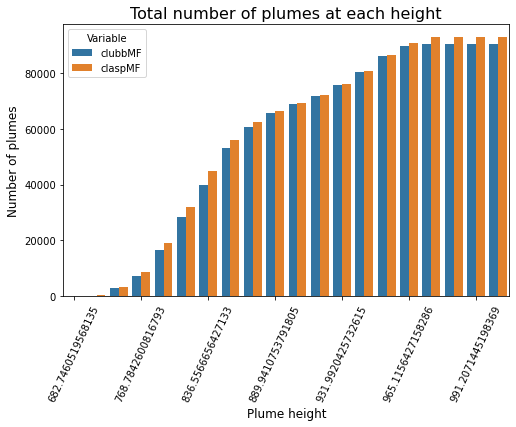

In [135]:
fig, ax = plt.subplots(figsize=(8, 5))    

levs = upthl_claspMF.levInterp.values
dfLevInfo = pd.DataFrame({'Level': levs[18::],
                          'clubbMF': countValPlumes_clubb[18::], 
                          'claspMF': countValPlumes_clasp[18::]})
tidy = dfLevInfo.melt(id_vars='Level').rename(columns=str.title)

g = sns.barplot(x='Level',y='Value',hue='Variable',data=tidy)
# xtix = ax.get_xticks()
ax.set_xticks(xtix[::3])
plt.xticks(rotation=65)
ax.set_ylabel('Number of plumes',fontsize=12)
ax.set_xlabel('Plume height',fontsize=12)
ax.set_title('Total number of plumes at each height', fontsize=16)

plt.show()

### Diurnal cycle plots

In [26]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

# hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')

hourlyMeanCLM_h0 = clmDS_h0.groupby('time.hour').mean(dim='time')
hourlyMeanCLM_h1 = clmDS_h1.groupby('time.hour').mean(dim='time')


# ## Get mean hourly LES values too 
# hrLES_newDefault = LES_newDefault.groupby('Time.hour').mean(dim='Time')
# hrLES_moments    = LES_allDays_allVarsHr.groupby('time.hour').mean(dim='time')



In [61]:
# pltVar = 'RTPTHLP_CLUBB'

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# # ctrlCase2 = 'clubbMF_setSfcFlux'
# # testCase2 = 'claspMF_setSfcFlux'

# fig,axs = plt.subplots(1,1, figsize=(7,4))

# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase).isel(ilev=-1).values)*1e-3, 
#          color='orangered', label=ctrlCase)
# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase).isel(ilev=-1).values)*1e-3, 
#          color='dodgerblue', label=testCase)

# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase2).isel(ilev=-1).values)*1e-3, 
# #          color='orangered', linestyle='--', label=ctrlCase2)
# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase2).isel(ilev=-1).values)*1e-3, 
# #          color='dodgerblue', linestyle='--', label=testCase2)

# axs.legend(fontsize=12)

# axs.set_ylabel('K kg/kg')
# axs.set_xlabel('Hour')
# axs.set_title(pltVar +' (ilev=-1 [~30m])', fontsize=14)


In [62]:
# pltVar = 'THLP2_CLUBB'

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# ctrlCase2 = 'clubbMF_setSfcFlux'
# testCase2 = 'claspMF_setSfcFlux'

# fig,axs = plt.subplots(1,1, figsize=(7,4))

# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase).isel(ilev=-1).values), 
#          color='orangered', label=ctrlCase)
# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase).isel(ilev=-1).values), 
#          color='dodgerblue', label=testCase)

# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase2).isel(ilev=-1).values), 
# #          color='orangered', linestyle='--', label=ctrlCase2)
# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase2).isel(ilev=-1).values), 
# #          color='dodgerblue', linestyle='--', label=testCase2)

# axs.legend(fontsize=12)

# axs.set_ylabel('K**2')
# axs.set_xlabel('Hour')
# axs.set_title(pltVar +' (ilev=-1 [~30m])', fontsize=14)



In [63]:
# pltVar = 'RTP2_CLUBB'

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# ctrlCase2 = 'clubbMF_setSfcFlux'
# testCase2 = 'claspMF_setSfcFlux'

# fig,axs = plt.subplots(1,1, figsize=(7,4))

# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase).isel(ilev=-1).values)*((1e-3)**2), 
#          color='orangered', label=ctrlCase)
# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase).isel(ilev=-1).values)*((1e-3)**2), 
#          color='dodgerblue', label=testCase)

# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase2).isel(ilev=-1).values)*((1e-3)**2), 
# #          color='orangered', linestyle='--', label=ctrlCase2)
# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase2).isel(ilev=-1).values)*((1e-3)**2), 
# #          color='dodgerblue', linestyle='--', label=testCase2)


# axs.legend(fontsize=12)

# axs.set_ylabel('kg**2/kg**2')
# axs.set_xlabel('Hour')
# axs.set_title(pltVar +' (ilev=-1 [~30m])', fontsize=14)




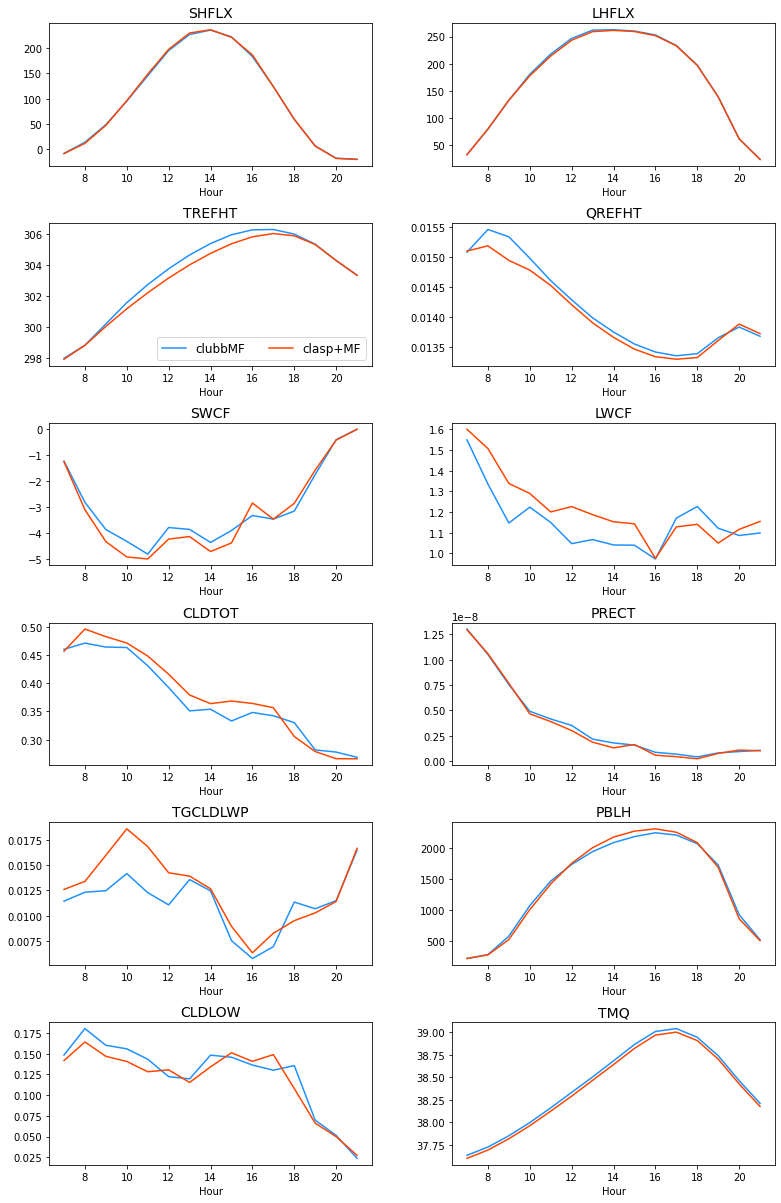

In [30]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
           'SWCF','LWCF',
           'CLDTOT','PRECT',
           'TGCLDLWP','PBLH',
           'CLDLOW','TMQ']

ctrlCase  = 'clubbMF'
testCase  = 'clasp+MF'

ctrlCase2 = 'clubbMF_setSfcFlux'
testCase2 = 'claspMF_setSfcFlux'

fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(13,3.5*len(pltVars)/2) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

for iPlt in range(len(pltVars)):

    axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values), 
             color='dodgerblue', label=ctrlCase)
    axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
    
#     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)

    if iPlt==2:
        axs[iPlt].legend(fontsize=12, ncol=2)

    # axs.set_ylabel('K kg/kg')
    axs[iPlt].set_xlabel('Hour')
    axs[iPlt].set_title(pltVars[iPlt], fontsize=14)


In [26]:
uniqDays_scamHMG = scamDS.sel(case='clubbMF').resample(time='1D').mean().dropna(dim='time').time.values
print('SCAM days:    ',    len(uniqDays_scamHMG))
dates            = pd.DatetimeIndex(uniqDays_scamHMG)


SCAM days:     74


In [ ]:
# pltVars = [
#            'PRECT',
#            'TGCLDLWP',
#            ]

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(11,3.25*len(pltVars)/2) )
# axs      = axs.ravel()
# fig.subplots_adjust(wspace=0.25, hspace=0.4)

# for iPlt in range(len(pltVars)):

# #     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values), 
# #              color='orangered',linewidth=3, label=ctrlCase)
# #     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values), 
# #              color='dodgerblue',linewidth=3, label=testCase)
# #     axs[iPlt].legend(fontsize=12)
    
#     for iDay in range(len(dates)):
#         iselDate = np.where( (scamDS['time.year'].values==dates.year[iDay]) & 
#                              (scamDS['time.month'].values==dates.month[iDay]) & 
#                              (scamDS['time.day'].values==dates.day[iDay]) )[0]
#         scamSel = scamDS.isel(time=iselDate).groupby('time.hour').mean(dim='time')
        
# #         axs[iPlt].plot(scamSel['hour'].values, np.squeeze(scamSel[pltVars[iPlt]].sel(case=ctrlCase).values), 
# #              color='orangered',linewidth=0.5,alpha=0.4, label=ctrlCase)
#         axs[iPlt].plot(scamSel['hour'].values, 
#                        np.squeeze(scamSel[pltVars[iPlt]].sel(case=testCase).values - scamSel[pltVars[iPlt]].sel(case=ctrlCase).values), 
#              color='k',linewidth=0.5,alpha=0.4, label=testCase)

#     # axs.set_ylabel('K kg/kg')
#     axs[iPlt].set_xlabel('Hour')
#     axs[iPlt].set_title(pltVars[iPlt]+' [clasp - clubb]', fontsize=14)


### Mean profiles at certain hours?

(0.0, 10.0)

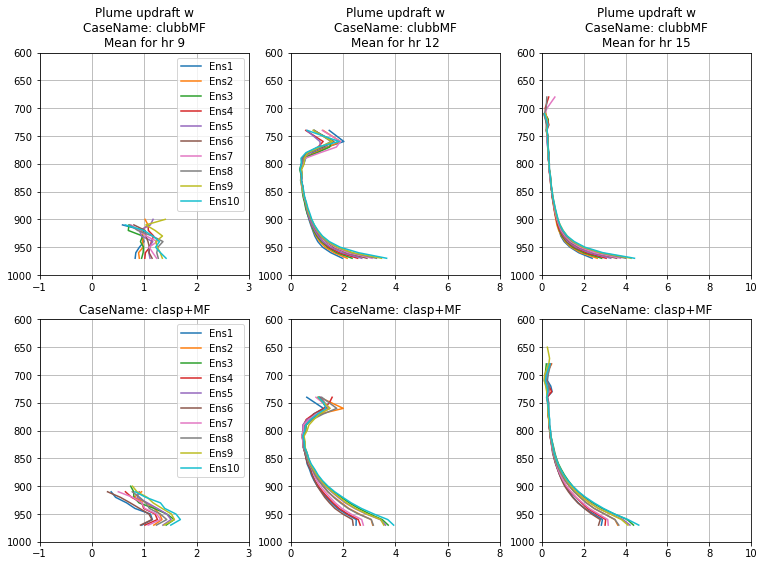

In [84]:
hoursList = [9,12,15]
fig,axs = plt.subplots(2,len(hoursList), figsize=(4.25*len(hoursList),9))
axs = axs.ravel()

caseSel1 = 'clubbMF'
caseSel2 = 'clasp+MF'
# caseSel1 = 'clubbMF_setSfcFlux'
# caseSel2 = 'claspMF_setSfcFlux'

# varSel   = 'edmf_upqt_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft qt'

# varSel   = 'edmf_upthl_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft thl'

varSel   = 'edmf_upw_interp' 
levVar   = 'levInterp'
longName = 'Plume updraft w'

# varSel   = 'edmf_upbuoy_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft buoyancy'

# varSel   = 'edmf_updet_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft detrainment'

# varSel   = 'edmf_upa_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft area'

for iHour in range(len(hoursList)):
    hourSel = hoursList[iHour]

    for iEns in range(len(hourlyMeanSCAM_h2.nens.values)):
        ensSel1 = hourlyMeanSCAM_h2.sel(hour=hourSel, case=caseSel1).isel(lon=0,lat=0,nens=iEns)
        ensSel2 = hourlyMeanSCAM_h2.sel(hour=hourSel, case=caseSel2).isel(lon=0,lat=0,nens=iEns)

        axs[iHour].plot(ensSel1[varSel].values, ensSel1[levVar].values, label='Ens'+str(iEns+1))
        axs[iHour+3].plot(ensSel2[varSel].values, ensSel2[levVar].values, label='Ens'+str(iEns+1))

    if iHour==0:
        axs[iHour].legend()
        axs[iHour+3].legend()
    
    axs[iHour].invert_yaxis()
    axs[iHour+3].invert_yaxis()

    axs[iHour].set_ylim([1000,600])
    axs[iHour+3].set_ylim([1000,600])

    axs[iHour].set_title(longName+'\nCaseName: '+caseSel1+'\nMean for hr '+str(hourSel))
    axs[iHour+3].set_title('CaseName: '+caseSel2)

    axs[iHour].grid()
    axs[iHour+3].grid()

# # EDMF_upthl limits: 
# axs[0].set_xlim([296,303])
# axs[3].set_xlim([296,303])

# axs[1].set_xlim([303,311])
# axs[4].set_xlim([303,311])

# axs[2].set_xlim([307,315])
# axs[5].set_xlim([307,315])

# # EDMF_upqt limits: 
# axs[0].set_xlim([0.01,0.0145])
# axs[3].set_xlim([0.01,0.0145])

# axs[1].set_xlim([0.008, 0.012])
# axs[4].set_xlim([0.008, 0.012])

# axs[2].set_xlim([0.008, 0.0115])
# axs[5].set_xlim([0.008, 0.0115])

# EDMF_upw limits: 
axs[0].set_xlim([-1,3])
axs[3].set_xlim([-1,3])

axs[1].set_xlim([0, 8])
axs[4].set_xlim([0, 8])

axs[2].set_xlim([0, 10])
axs[5].set_xlim([0, 10])



(300.0, 315.0)

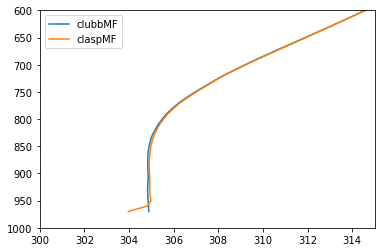

In [49]:
fig,axs = plt.subplots(1,1, figsize=(6,4))

hrSel = 15

axs.plot(np.squeeze(hourlyMeanSCAM.sel(case='clubbMF',hour=hrSel).THETAL_interp.values), 
         hourlyMeanSCAM.levInterp.values, label='clubbMF')
axs.plot(np.squeeze(hourlyMeanSCAM.sel(case='clasp+MF',hour=hrSel).THETAL_interp.values), 
         hourlyMeanSCAM.levInterp.values, label='claspMF')
axs.legend()
axs.invert_yaxis()
axs.set_ylim([1000,600])
axs.set_xlim([300,315])


Text(0.5, 0, 'm^2 s^-2')

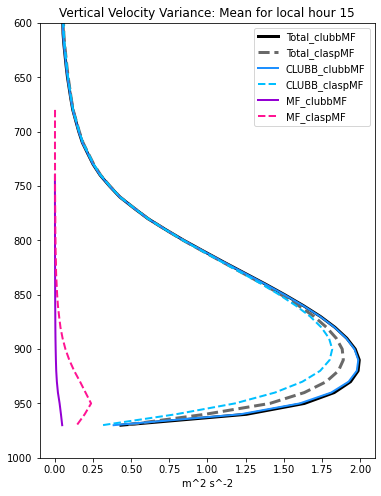

In [85]:
fig,axs = plt.subplots(1,1, figsize=(6,8))

# totVar   = 'total_thlp2'
# clubbVar = 'THLP2_CLUBB_interp'
# mfVar    = 'edmf_thlp2'
# unitsStr = 'K^2'
# varName  = 'Temp Variance'


totVar   = 'total_wp2'
clubbVar = 'WP2_CLUBB_interp'
mfVar    = 'edmf_wp2'
unitsStr = 'm^2 s^-2'
varName  = 'Vertical Velocity Variance'


maxLev   = 600 
selHr    = 15

colorsel = ['black','deepskyblue','deeppink']

axs.plot(hourlyMeanSCAM_h2[totVar].isel(lon=0,lat=0).sel(case='clubbMF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='black',linestyle='-', linewidth=3, 
            label='Total_clubbMF')
axs.plot(hourlyMeanSCAM_h2[totVar].isel(lon=0,lat=0).sel(case='clasp+MF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='dimgrey',linestyle='--', linewidth=3, 
            label='Total_claspMF')

axs.plot(hourlyMeanSCAM[clubbVar].isel(lon=0,lat=0).sel(case='clubbMF',hour=selHr), 
            hourlyMeanSCAM.levInterp.values, 
            color='dodgerblue',linestyle='-', linewidth=2, 
            label='CLUBB_clubbMF')
axs.plot(hourlyMeanSCAM[clubbVar].isel(lon=0,lat=0).sel(case='clasp+MF',hour=selHr), 
            hourlyMeanSCAM.levInterp.values, 
            color='deepskyblue',linestyle='--', linewidth=2, 
            label='CLUBB_claspMF')

axs.plot(hourlyMeanSCAM_h2[mfVar].isel(lon=0,lat=0).sel(case='clubbMF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='darkviolet',linestyle='-', linewidth=2, 
            label='MF_clubbMF')
axs.plot(hourlyMeanSCAM_h2[mfVar].isel(lon=0,lat=0).sel(case='clasp+MF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='deeppink',linestyle='--', linewidth=2, 
            label='MF_claspMF')

# axs[0].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
#             scamDS.levInterp.values, 
#             color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
#             label='CLUBBpart')

# axs[0].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
#             scamDS_h2.levInterp.values, 
#             color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
#             label='MFpart')


axs.legend()
axs.invert_yaxis()
axs.set_ylim([1000,maxLev])
axs.set_title(varName+': Mean for local hour '+str(selHr))
axs.set_xlabel(unitsStr)

# axs.axvline(0,color='orange',alpha=0.9,linestyle=':')

In [48]:
sumVar = hourlyMeanSCAM[clubbVar].isel(lon=0,lat=0).sel(case='clubbMF',hour=selHr) + hourlyMeanSCAM_h2[mfVar].isel(lon=0,lat=0).sel(case='clubbMF',hour=selHr) 



In [53]:
for ilev in range(len(hourlyMeanSCAM.levInterp.values)):
    if sumVar[ilev]==hourlyMeanSCAM_h2[totVar].isel(lon=0,lat=0,levInterp=ilev).sel(case='clubbMF',hour=selHr):
        print('cool, match at level ', hourlyMeanSCAM.levInterp.values[ilev])
    else:
        print('ERROR at level ', hourlyMeanSCAM.levInterp.values[ilev])
        print('   sumVar = ',sumVar[ilev].values)
        print('   levVar = ',hourlyMeanSCAM_h2[totVar].isel(lon=0,lat=0,levInterp=ilev).sel(case='clubbMF',hour=selHr).values)
    

ERROR at level  200.0
   sumVar =  nan
   levVar =  0.00047559375509907204
ERROR at level  210.0
   sumVar =  nan
   levVar =  0.0007872205995974088
ERROR at level  220.0
   sumVar =  nan
   levVar =  0.002643081742030705
ERROR at level  230.0
   sumVar =  nan
   levVar =  0.005237522053808537
ERROR at level  240.0
   sumVar =  nan
   levVar =  0.007782714328363675
ERROR at level  250.0
   sumVar =  nan
   levVar =  0.009747493744066119
ERROR at level  260.0
   sumVar =  nan
   levVar =  0.011079700580716863
ERROR at level  270.0
   sumVar =  nan
   levVar =  0.012348893066703948
ERROR at level  280.0
   sumVar =  nan
   levVar =  0.013884272864720326
ERROR at level  290.0
   sumVar =  nan
   levVar =  0.017801212615362796
ERROR at level  300.0
   sumVar =  nan
   levVar =  0.023551132427306786
ERROR at level  310.0
   sumVar =  nan
   levVar =  0.02790933090652206
ERROR at level  320.0
   sumVar =  nan
   levVar =  0.03116845289366145
ERROR at level  330.0
   sumVar =  nan
   levVar =

In [51]:
hourlyMeanSCAM_h2[totVar].isel(lon=0,lat=0).sel(case='clubbMF',hour=selHr)

<xarray.DataArray 'total_wp2' (levInterp: 78)>
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.22998345e-06, 9.70049362e-07, 8.80336678e-07, 8.43398770e-07,
       8.55400036e-07, 1.13467130e-06, 8.36841092e-05, 9.36952369e-05,
       2.45228026e-04, 4.13813460e-04, 7.17464029e-04, 1.14103172e-03,
       1.85543805e-03, 3.10231593e-03, 4.62461779e-03, 6.15246216e-03,
       9.73704171e-03, 1.37721079e-02, 1.99769230e-02, 2.77357764e-02,
       3.72086831e-02, 5.11592783e-02, 7.02023231e-02, 9.58412349e-02,
       1.28165068e-01, 1.68663159e-01, 2.11974908e-01, 2.60230380e-01,
       2.32814646e-01, 1.91767157e-01])
Coordinates:
    lat        float64 36.6
    lon        float64 262.5
  * levInterp  (levInterp) float64 200.0 210.0 220.0 230.0 ... 950.0 960.0 970.0
    case       <U7 'clubbMF'
    hour       int64 15

### Look at mean over certain periods

In [151]:
iMorn = np.where((scamDS['time.hour'].values>=8) & (scamDS['time.hour'].values<=10))[0]
iAftn = np.where((scamDS['time.hour'].values>=12) & (scamDS['time.hour'].values<=17))[0]
iEvng = np.where((scamDS['time.hour'].values>=18) & (scamDS['time.hour'].values<=20))[0]

mornDS = scamDS.isel(time=iMorn, lat=0, lon=0).mean(dim='time')
aftnDS = scamDS.isel(time=iAftn, lat=0, lon=0).mean(dim='time')
evngDS = scamDS.isel(time=iEvng, lat=0, lon=0).mean(dim='time')

mornDS_h2 = scamDS_h2.isel(time=iMorn, lat=0, lon=0).mean(dim='time')
aftnDS_h2 = scamDS_h2.isel(time=iAftn, lat=0, lon=0).mean(dim='time')
evngDS_h2 = scamDS_h2.isel(time=iEvng, lat=0, lon=0).mean(dim='time')


In [153]:
tableVars = ['PRECT','CLDTOT','TGCLDLWP','TMQ','CLDLOW']

print('                                       clubb/clasp')
print('                    (8-10a)             (12-5p)                (6-8p)')
print('Variable          MorningMean        AfternoonMean        EveningMean')
  
for iVar in range(len(tableVars)):
    print('%10s  %8.3f / %7.3f  %8.3f / %7.3f  %8.3f / %7.3f' % (tableVars[iVar], 
                    mornDS[tableVars[iVar]].sel(case='clubbMF'), mornDS[tableVars[iVar]].sel(case='clasp+MF'), 
                    aftnDS[tableVars[iVar]].sel(case='clubbMF'), aftnDS[tableVars[iVar]].sel(case='clasp+MF'), 
                    evngDS[tableVars[iVar]].sel(case='clubbMF'), evngDS[tableVars[iVar]].sel(case='clasp+MF'), 
                                  ) )
    
    

                                       clubb/clasp
                    (8-10a)             (12-5p)                (6-8p)
Variable          MorningMean        AfternoonMean        EveningMean
     PRECT     0.000 /   0.000     0.000 /   0.000     0.000 /   0.000
    CLDTOT     0.372 /   0.384     0.359 /   0.351     0.289 /   0.311
  TGCLDLWP     0.012 /   0.011     0.010 /   0.011     0.009 /   0.009
       TMQ    34.171 /  34.156    33.789 /  33.771    33.017 /  32.995
    CLDLOW     0.114 /   0.130     0.123 /   0.122     0.029 /   0.036


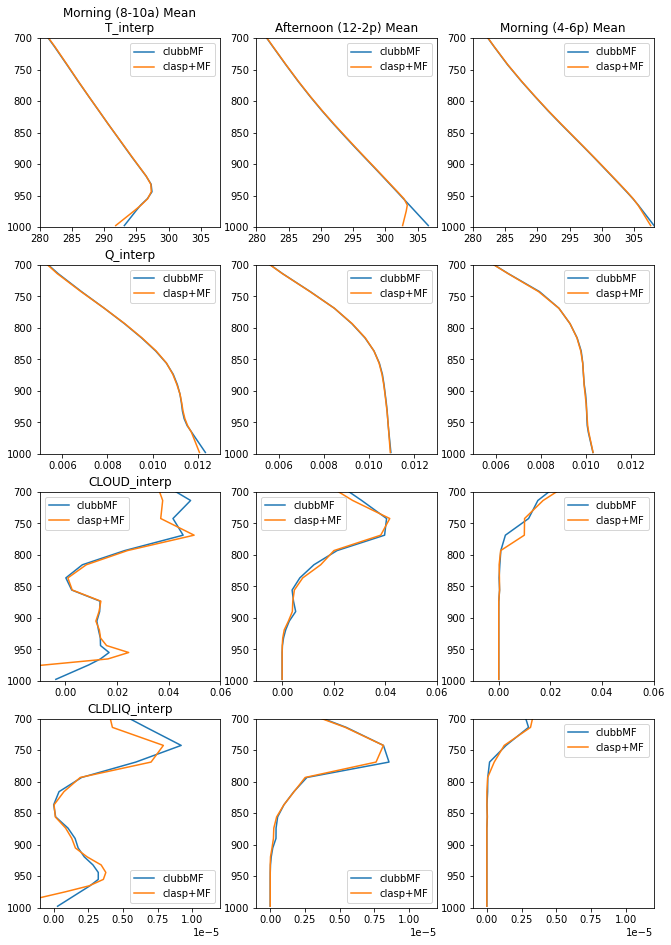

In [154]:
pltVars = ['T_interp','Q_interp','CLOUD_interp','CLDLIQ_interp']

ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

maxLev   = 700

minX = [280, 0.005, -0.01, -0.1e-5]
maxX = [308, 0.013, 0.06,  1.2e-5]

useH2 = False

fig,axs = plt.subplots(len(pltVars),3, figsize=(11,4*len(pltVars)))
axs = axs.ravel()

for iVar in range(len(pltVars)):
    if useH2: 
        axs[(iVar*3)].plot(mornDS_h2[pltVars[iVar]].sel(case=ctrlCase).values, 
                           mornDS_h2.levInterp.values)
    else: 
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           mornDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=testCase).values), 
                           mornDS.levInterp.values, label=testCase)
        
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           aftnDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=testCase).values), 
                           aftnDS.levInterp.values, label=testCase)
    
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           evngDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=testCase).values), 
                           evngDS.levInterp.values, label=testCase)
        
    axs[(iVar*3)].legend()
    axs[(iVar*3)].invert_yaxis()
    axs[(iVar*3)].set_ylim([1000, maxLev])
    axs[(iVar*3)].set_xlim([minX[iVar], maxX[iVar]])
    
        
    axs[(iVar*3)+1].legend()
    axs[(iVar*3)+1].invert_yaxis()
    axs[(iVar*3)+1].set_ylim([1000, maxLev])
    axs[(iVar*3)+1].set_xlim([minX[iVar], maxX[iVar]])
    
    axs[(iVar*3)+2].legend()
    axs[(iVar*3)+2].invert_yaxis()
    axs[(iVar*3)+2].set_ylim([1000, maxLev])
    axs[(iVar*3)+2].set_xlim([minX[iVar], maxX[iVar]])
    
    if iVar==0:
        axs[iVar+0].set_title('Morning (8-10a) Mean\n'+pltVars[iVar])
        axs[iVar+1].set_title('Afternoon (12-2p) Mean')
        axs[iVar+2].set_title('Morning (4-6p) Mean')
    else:
        axs[iVar*3].set_title(pltVars[iVar])

    

### Time-height plots

In [36]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')
hourlyStdSCAM_h2   = scamDS_h2.groupby('time.hour').std(dim='time')
hourlyCountSCAM_h2 = scamDS_h2.groupby('time.hour').count(dim='time')
hourlySE_h2 = hourlyStdSCAM_h2/np.sqrt(hourlyCountSCAM_h2)


In [37]:
## Add significance testing 
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

CI = CIlevel*hourlySE
lowCI = hourlyMeanSCAM - CI
hghCI = hourlyMeanSCAM + CI

# CI_h2 = CIlevel*hourlySE_h2
# lowCI_h2 = hourlyMeanSCAM_h2 - CI_h2
# hghCI_h2 = hourlyMeanSCAM_h2 + CI_h2




**SCAM HOM case and HET-HOM case**

In [158]:
np.nanmax(hourlyMeanSCAM.QT_interp.values)

0.01271376583545383

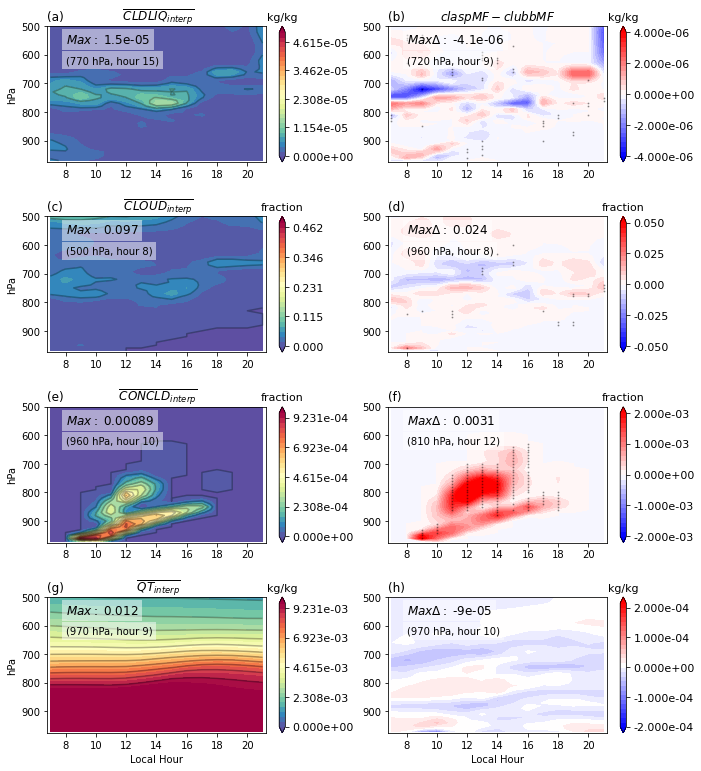

In [38]:
# Set up figure
pltVars  = ['CLDLIQ_interp', 
            'CLOUD_interp',
            'CONCLD_interp',
            'QT_interp',
           ]

cMin    = [0.0, 
           0.0,
           0.0,
           0.0,
          ]

cMax    = [0.5e-4,
           0.5,
           0.1e-2,
           0.1e-1,
          ]

diffMax = [0.4e-5,
           0.05,
           0.2e-2, 
           0.2e-3, 
          ]

multpl = [
          1,
          1,
          1,
          1, 
         ]

maxLev  = 500

units = [
         r'kg/kg',
         r'fraction',
         r'fraction',
         r'kg/kg', 
        ]

cfmt_hmg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater




subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r" $\overline{CLDLIQ_{interp}}$",
               r" $\overline{CLOUD_{interp}}$",
               r" $\overline{CONCLD_{interp}}$",
               r" $\overline{QT_{interp}}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

# ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
# testDS    = hourlyMeanSCAM.sel(case=testCase)
# diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
    
    if pltVars[iVar]=='edmf_cloudfrac_interp':
        ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
        diffCases = testDS - ctrlDS        
    else:
        ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM.sel(case=testCase)
        diffCases = testDS - ctrlDS
    
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')
        




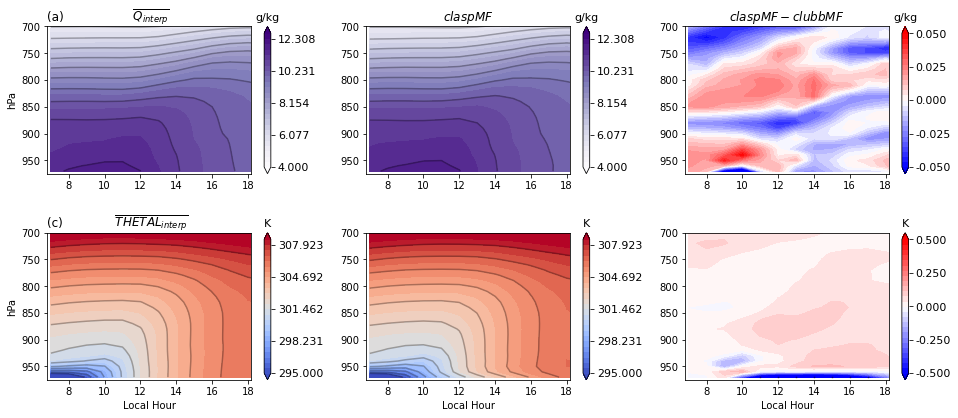

In [68]:
# Set up figure
pltVars  = ['Q_interp',
            'THETAL_interp',
           ]

cMin    = [4, 
           295.0,
          ]

cMax    = [13,
           309,
          ]

diffMax = [0.05,
           0.5,
          ]

multpl = [
          1e3,
          1,
         ]

maxLev  = 700

units = [
         r'g/kg',
         r'K',
        ]

cfmt_hmg = ['%.3f', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3f', '%.3f'] # colorbar label formater

cmapSel = ['Purples', 'coolwarm']


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r" $\overline{Q_{interp}}$",
               r" $\overline{THETAL_{interp}}$",
              ]


fig, axs = plt.subplots(len(pltVars), 3, figsize=(16,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

for iVar in range(len(pltVars)): 
    
    if pltVars[iVar]=='edmf_cloudfrac_interp':
        ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
        diffCases = testDS - ctrlDS        
    else:
        ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM.sel(case=testCase)
        diffCases = testDS - ctrlDS
    
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*3].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap=cmapSel[iVar], extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*3)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*3)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*3].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
#     ## Add inset text for max/min
#     varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

#     axs[iVar*3].text(8,760,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
#                 fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
#     axs[iVar*3].text(8,830,'(%i hPa, hour %i)' % (varHgt,varTime), 
#                 fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))


    # - - - - Plot test case - - - -
    cplt = axs[(iVar*3)+1].contourf(testDS.hour.values, testDS.levInterp.values, 
                       np.squeeze(testDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap=cmapSel[iVar], extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*3)+1], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*3)+1], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[(iVar*3)+1].contour(testDS.hour.values, testDS.levInterp.values, 
                    np.squeeze(testDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
#     ## Add inset text for max/min
#     varVal,varHgt,varTime = getMaxValHeightTime(testDS, pltVars[iVar], maxLev, 'levInterp','hour')

#     axs[(iVar*3)+1].text(8,760,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
#                 fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
#     axs[(iVar*3)+1].text(8,830,'(%i hPa, hour %i)' % (varHgt,varTime), 
#                 fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))


    
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*3)+2].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*3)+2], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
#     ## Add inset text for max difference 
#     diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
#     axs[(iVar*3)+2].text(8,760,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
#                 fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
#     axs[(iVar*3)+2].text(8,830,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
#                 fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*3)+2].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*3].invert_yaxis()
    axs[(iVar*3)+1].invert_yaxis()
    axs[(iVar*3)+2].invert_yaxis()

    axs[(iVar*3)].set_ylim([975, maxLev])
    axs[(iVar*3)+1].set_ylim([975, maxLev])
    axs[(iVar*3)+2].set_ylim([975, maxLev])

    axs[(iVar*3)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*3)].set_title(varLabel[iVar])
    
    if iVar==0:
#         axs[(iVar*3)+2].set_title(subPltLabel[iVar][1], loc='left')
#         axs[(iVar*3)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*3)+2].set_title(r'$claspMF - clubbMF$')
        axs[(iVar*3)+1].set_title(r'$claspMF$')
#     else: 
#         axs[(iVar*3)+1].set_title(subPltLabel[iVar][1], loc='left')
#         axs[(iVar*3)+2].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*3)].set_ylabel('hPa')
    
    axs[(iVar*3)].set_xlim([6.8,18.2])
    axs[(iVar*3)+1].set_xlim([6.8,18.2])
    axs[(iVar*3)+2].set_xlim([6.8,18.2])
    axs[(iVar*3)].set_xticks([8,10,12,14,16,18])
    axs[(iVar*3)+1].set_xticks([8,10,12,14,16,18])
    axs[(iVar*3)+2].set_xticks([8,10,12,14,16,18])

    
    if iVar==len(pltVars)-1: 
        axs[(iVar*3)].set_xlabel('Local Hour')
        axs[(iVar*3)+1].set_xlabel('Local Hour')
        axs[(iVar*3)+2].set_xlabel('Local Hour')

plt.show()


In [ ]:
# CI_h2 = CIlevel*hourlySE_h2
# lowCI_h2 = hourlyMeanSCAM_h2 - CI_h2
# hghCI_h2 = hourlyMeanSCAM_h2 + CI_h2

In [69]:
CI_h2           = CIlevel*hourlySE_h2.sel(case=ctrlCase).isel(lon=0,lat=0)['total_wp2']
ctrlDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)['total_wp2'], -CI_h2])

ctrlDS_lowCI

207.62308769508334

In [70]:
np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)['total_wp2'], -CI_h2], axis=0)[1,-1]

0.1040094535342929

In [71]:
CI_h2.values[1,-1]

0.008573950331313085

In [72]:
hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)['total_wp2'].values[1,-1] 

0.11258340386560599

In [105]:
def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase, CIlevel): 

    ## Get ranges for each case's CI 
    CI_h2_ctrl           = CIlevel*hourlySE_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel]
    CI_h2_test           = CIlevel*hourlySE_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel]

#     ctrlDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], -CI_h2_ctrl], axis=0)
#     testDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], -CI_h2_test], axis=0)

#     ctrlDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], CI_h2_ctrl], axis=0)
#     testDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], CI_h2_test], axis=0)

    ctrlDS_lowCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel] -CI_h2_ctrl
    testDS_lowCI    = hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel] -CI_h2_test

    ctrlDS_hghCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel] + CI_h2_ctrl
    testDS_hghCI    = hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel] + CI_h2_test



    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

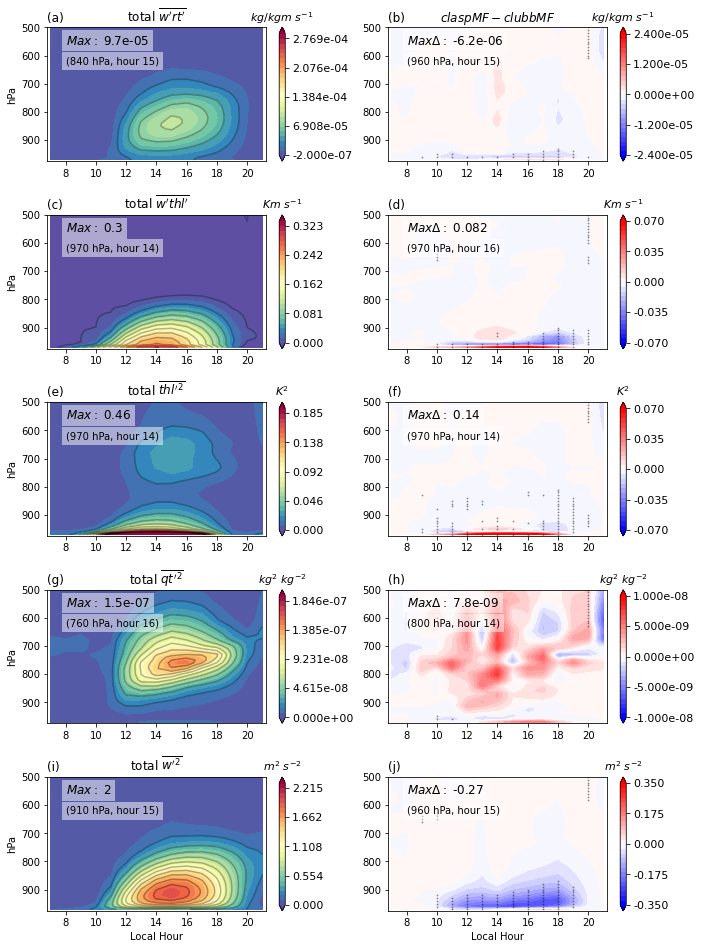

In [106]:
# Set up figure
pltVars  = [
            'total_wprtp',
            'total_wpthlp', 
            'total_thlp2',
            'total_rtp2',
            'total_wp2',
           ]

cMin    = [-2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [3e-4,
           0.35,
           0.2,
           2e-7,
           2.4,
          ]

diffMax = [2.4e-5,
           0.07,
           0.07, 
           1e-8,
           0.35,
          ]

multpl = [
          1,
          1,
          1,
          1, 
          1,
         ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater




subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"total $\overline{w'rt'}$",
               r"total $\overline{w'thl'}$",
               r"total $\overline{thl'^2}$",
               r"total $\overline{qt'^2}$",
               r"total $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase, CIlevel)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


### Grab a few days at random and look at individual days

In [161]:
yrSelList  = [2017,2016,2017]
monSelList = [9,   6,   7]
daySelList = [24,  10,  16]

iselDate1 = np.where( (scamDS['time.year'].values==yrSelList[0]) & 
                      (scamDS['time.month'].values==monSelList[0]) & 
                      (scamDS['time.day'].values==daySelList[0]) )[0]
scamSel1 = scamDS.isel(time=iselDate1).groupby('time.hour').mean(dim='time')


iselDate2 = np.where( (scamDS['time.year'].values==yrSelList[1]) & 
                      (scamDS['time.month'].values==monSelList[1]) & 
                      (scamDS['time.day'].values==daySelList[1]) )[0]
scamSel2 = scamDS.isel(time=iselDate2).groupby('time.hour').mean(dim='time')


iselDate3 = np.where( (scamDS['time.year'].values==yrSelList[2]) & 
                      (scamDS['time.month'].values==monSelList[2]) & 
                      (scamDS['time.day'].values==daySelList[2]) )[0]
scamSel3 = scamDS.isel(time=iselDate3).groupby('time.hour').mean(dim='time')



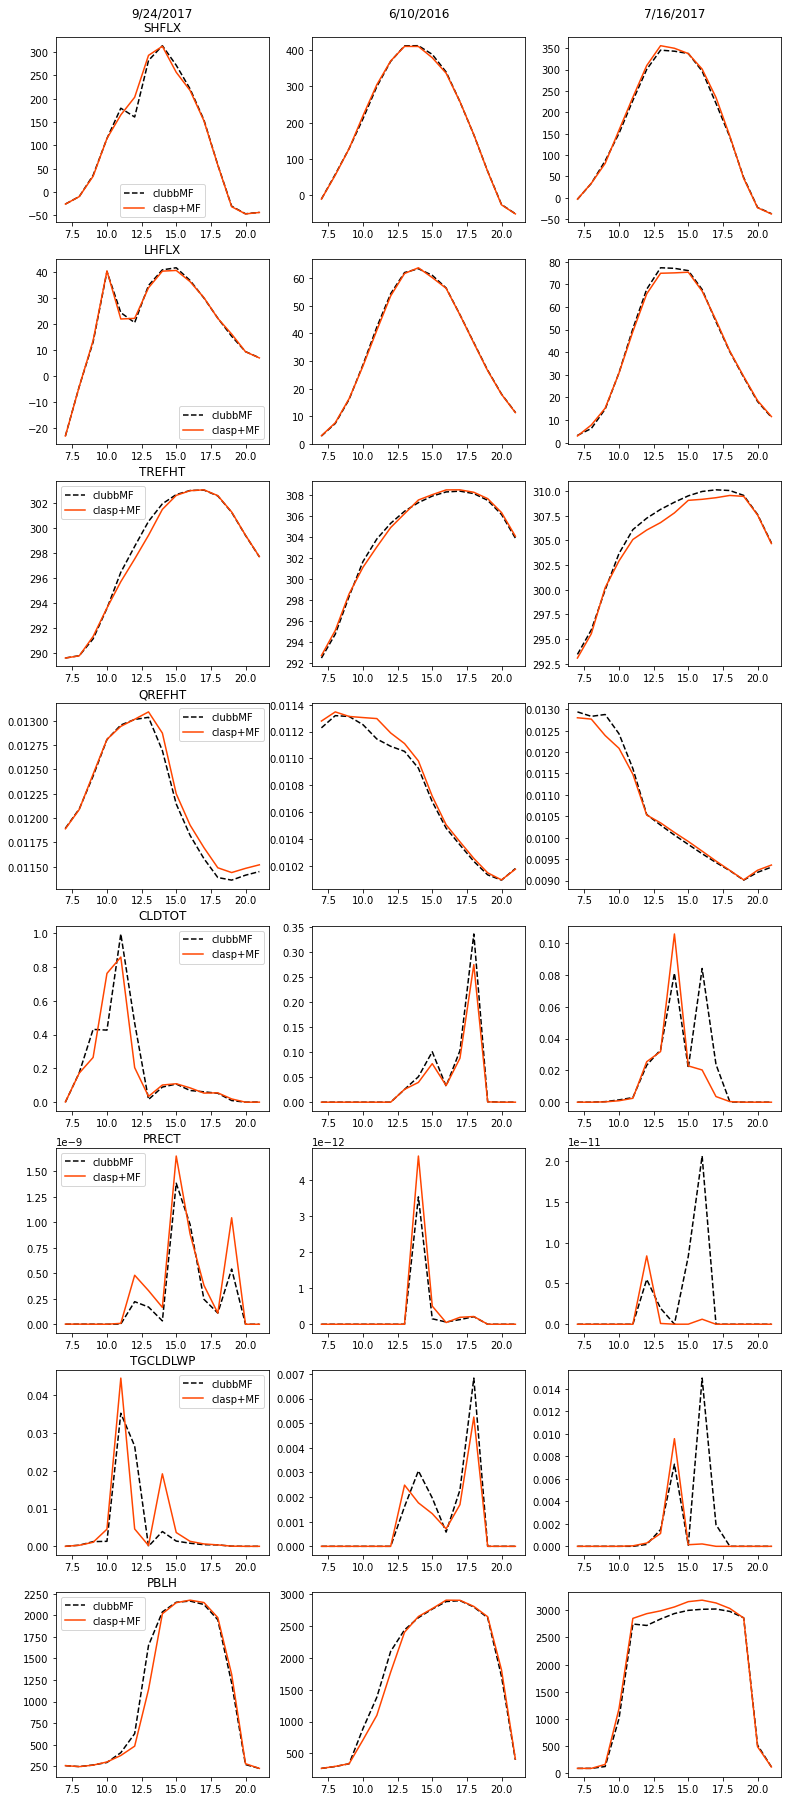

In [163]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
#            'SWCF','LWCF',
           'CLDTOT','PRECT',
           'TGCLDLWP','PBLH',]

ctrlCase  = 'clubbMF'
testCase  = 'clasp+MF'

# ctrlCase2 = 'clubbMF_setSfcFlux'
# testCase2 = 'claspMF_setSfcFlux'

fig,axs = plt.subplots(len(pltVars),3, figsize=(13,4*len(pltVars)))
axs     = axs.ravel()

for iPlt in range(len(pltVars)):

    ## Day 1
    axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)
    
    ## Day 2
    axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)

    ## Day 3
    axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)
    
    if iPlt==0: 
        axs[iPlt*3].set_title(str(monSelList[0])+'/'+str(daySelList[0])+'/'+str(yrSelList[0])+'\n'+pltVars[iPlt])
        axs[iPlt*3+1].set_title(str(monSelList[1])+'/'+str(daySelList[1])+'/'+str(yrSelList[1])+'\n')
        axs[iPlt*3+2].set_title(str(monSelList[2])+'/'+str(daySelList[2])+'/'+str(yrSelList[2])+'\n')
    else: 
        axs[iPlt*3].set_title(pltVars[iPlt])
        
    axs[iPlt*3].legend()
    
    

Text(0.5, 0, 'Local Hour')

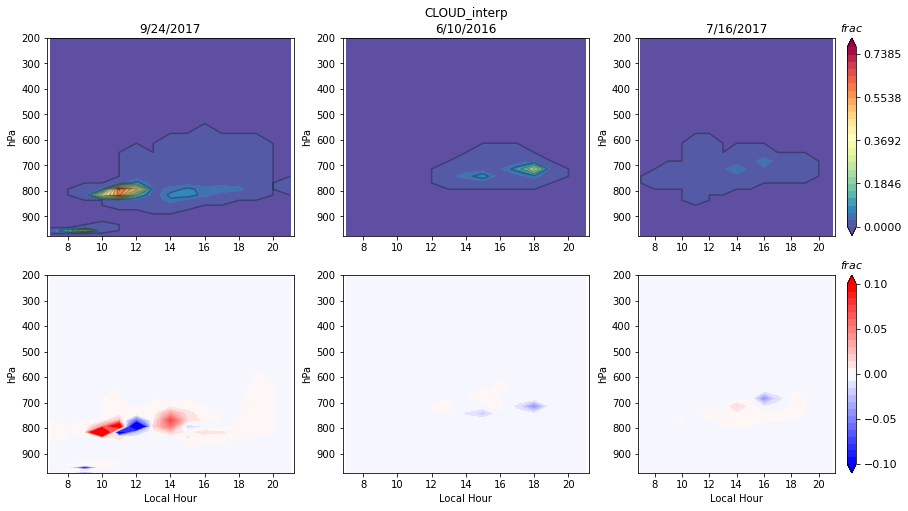

In [41]:
# pltVar  = 'THLP2_CLUBB_interp'
# cMin    = 0.0 
# cMax    = 0.1
# diffMax = 0.01
# multpl  = 1 
# maxLev  = 500 
# unitsStr = r'$K^2$'

# pltVar  = 'RTP2_CLUBB_interp'
# cMin    = 0.0 
# cMax    = 2.0e-7
# diffMax = 0.4e-7
# multpl  = 1e-6 
# maxLev  = 500 
# unitsStr = r'$kg^2/kg^2$'

pltVar  = 'CLOUD_interp'
cMin    = 0.0 
cMax    = 0.8
diffMax = 0.1
multpl  = 1 
maxLev  = 200 
unitsStr = r'$frac$'

fig,axs = plt.subplots(2,3, figsize=(15,8))
axs     = axs.ravel()

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'


## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 1 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel1.sel(case=ctrlCase)
testDS    = scamSel1.sel(case=testCase)
diffCases = testDS - ctrlDS
# - - - - Plot control case - - - -
cplt = axs[0].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')

# Add contour lines
cplt = axs[0].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )

# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[3].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 2
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel2.sel(case=ctrlCase)
testDS    = scamSel2.sel(case=testCase)
diffCases = testDS - ctrlDS
# - - - - Plot control case - - - -
cplt = axs[1].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')

# Add contour lines
cplt = axs[1].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )


# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[4].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 3 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel3.sel(case=ctrlCase)
testDS    = scamSel3.sel(case=testCase)
diffCases = testDS - ctrlDS

# - - - - Plot control case - - - -
cplt = axs[2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')
# Add colorbar
if (pltVar=='RTPTHLP_CLUBB_interp'):
        cbar = fig.colorbar(cplt, ax=axs[2],ticks=[cMin, cMin/2, 0, cMax/2, cMax])
else: 
    cbar = fig.colorbar(cplt, ax=axs[2])
    cbar.ax.locator_params(nbins=6)
cbar.ax.set_title(unitsStr, fontsize=11)
cbar.ax.tick_params(labelsize=11) 


# Add contour lines
cplt = axs[2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )


# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[5].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

cbar = fig.colorbar(cplt, ax=axs[5],ticks=[-diffMax, -diffMax/2, 0, diffMax/2, diffMax])
cbar.ax.locator_params(nbins=6)
cbar.ax.set_title(unitsStr, fontsize=11)
cbar.ax.tick_params(labelsize=11) 

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Other plot options 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

axs[0].set_title('\n'+str(monSelList[0])+'/'+str(daySelList[0])+'/'+str(yrSelList[0]))
axs[1].set_title(pltVar+'\n'+str(monSelList[1])+'/'+str(daySelList[1])+'/'+str(yrSelList[1]))
axs[2].set_title('\n'+str(monSelList[2])+'/'+str(daySelList[2])+'/'+str(yrSelList[2]))

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()


axs[0].set_ylim([975, maxLev])
axs[1].set_ylim([975, maxLev])
axs[2].set_ylim([975, maxLev])
axs[3].set_ylim([975, maxLev])
axs[4].set_ylim([975, maxLev])
axs[5].set_ylim([975, maxLev])

axs[0].set_ylabel('hPa')
axs[1].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[3].set_ylabel('hPa')
axs[4].set_ylabel('hPa')
axs[5].set_ylabel('hPa')

axs[0].set_xlim([6.8,21.2])
axs[1].set_xlim([6.8,21.2])
axs[2].set_xlim([6.8,21.2])
axs[3].set_xlim([6.8,21.2])
axs[4].set_xlim([6.8,21.2])
axs[5].set_xlim([6.8,21.2])

axs[0].set_xticks([8,10,12,14,16,18,20])
axs[1].set_xticks([8,10,12,14,16,18,20])
axs[2].set_xticks([8,10,12,14,16,18,20])
axs[3].set_xticks([8,10,12,14,16,18,20])
axs[4].set_xticks([8,10,12,14,16,18,20])
axs[5].set_xticks([8,10,12,14,16,18,20])

axs[3].set_xlabel('Local Hour')
axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')


## Assess what's happening in the land

## Scratch work

In [69]:
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxTRUE_fixEvap.LASSO_20180605.budgetMFvars001'
caseDir = '/project/amp/mdfowler/cases/'
histDir = '/run/atm/hist/'

listFiles_h2 = np.sort(glob.glob(caseDir+caseName+histDir+'*cam.h2*'))

testDS = xr.open_dataset(listFiles_h2[0], decode_times=True)


(1000.0, 500.0)

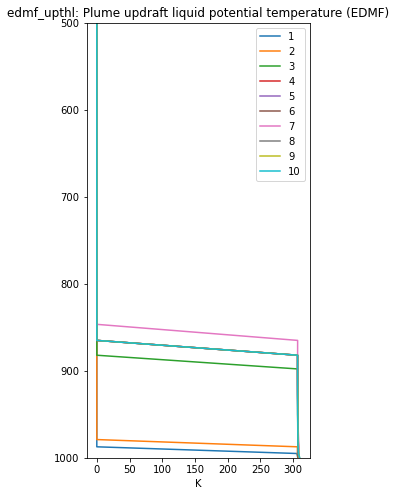

In [84]:
nens = 10
fig,axs = plt.subplots(1,1, figsize=(4,8))

pltVar = 'edmf_upthl'

for iEns in range(nens):
    axs.plot(testDS[pltVar].values[200,iEns,:,0,0], testDS.ilev.values,label=str(iEns+1))
    
axs.invert_yaxis()
axs.legend()
axs.set_title(pltVar+': '+testDS[pltVar].long_name)
axs.set_xlabel(testDS[pltVar].units)
axs.set_ylim([1000,500])


In [70]:
testDS

<xarray.Dataset>
Dimensions:         (ilev: 59, lat: 1, lev: 58, lon: 1, nbnd: 2, nens: 10, time: 865)
Coordinates:
  * lat             (lat) float64 36.6
  * lon             (lon) float64 262.5
  * lev             (lev) float64 3.018 5.445 9.087 14.25 ... 983.2 991.2 997.5
  * ilev            (ilev) float64 2.055 3.98 6.909 11.27 ... 987.4 995.1 1e+03
  * time            (time) object 2018-06-05 05:01:00 ... 2018-06-08 05:01:00
Dimensions without coordinates: nbnd, nens
Data variables:
    ntrk            int32 ...
    ntrn            int32 ...
    ntrm            int32 ...
    gw              (lat) float64 ...
    hyam            (lev) float64 ...
    hybm            (lev) float64 ...
    P0              float64 ...
    hyai            (ilev) float64 ...
    hybi            (ilev) float64 ...
    date            (time) int32 ...
    datesec         (time) int32 ...
    time_bnds       (time, nbnd) object ...
    date_written    (time) |S8 ...
    time_written    (time) |S8 ...
    ndbase          int32 ...
    nsbase          int32 ...
    nbdate          int32 ...
    nbsec           int32 ...
    mdt             int32 ...
    ndcur           (time) int32 ...
    nscur           (time) int32 ...
    co2vmr          (time) float64 ...
    ch4vmr          (time) float64 ...
    n2ovmr          (time) float64 ...
    f11vmr          (time) float64 ...
    f12vmr          (time) float64 ...
    sol_tsi         (time) float64 ...
    nsteph          (time) int32 ...
    edmf_DRY_A      (time, ilev, lat, lon) float32 ...
    edmf_DRY_QT     (time, ilev, lat, lon) float32 ...
    edmf_DRY_THL    (time, ilev, lat, lon) float32 ...
    edmf_DRY_W      (time, ilev, lat, lon) float32 ...
    edmf_MOIST_A    (time, ilev, lat, lon) float32 ...
    edmf_MOIST_QC   (time, ilev, lat, lon) float32 ...
    edmf_MOIST_QT   (time, ilev, lat, lon) float32 ...
    edmf_MOIST_THL  (time, ilev, lat, lon) float32 ...
    edmf_MOIST_W    (time, ilev, lat, lon) float32 ...
    edmf_cloudfrac  (time, lev, lat, lon) float32 ...
    edmf_dnqt       (time, nens, ilev, lat, lon) float32 ...
    edmf_dnthl      (time, nens, ilev, lat, lon) float32 ...
    edmf_dnw        (time, nens, ilev, lat, lon) float32 ...
    edmf_precc      (time, ilev, lat, lon) float32 ...
    edmf_qtflxdn    (time, ilev, lat, lon) float32 ...
    edmf_qtflxup    (time, ilev, lat, lon) float32 ...
    edmf_qtforcdn   (time, lev, lat, lon) float32 ...
    edmf_qtforcup   (time, lev, lat, lon) float32 ...
    edmf_rcm        (time, ilev, lat, lon) float32 ...
    edmf_thlflxdn   (time, ilev, lat, lon) float32 ...
    edmf_thlflxup   (time, ilev, lat, lon) float32 ...
    edmf_thlforcdn  (time, lev, lat, lon) float32 ...
    edmf_thlforcup  (time, lev, lat, lon) float32 ...
    edmf_upa        (time, nens, ilev, lat, lon) float32 ...
    edmf_upbuoy     (time, nens, ilev, lat, lon) float32 ...
    edmf_updet      (time, nens, ilev, lat, lon) float32 ...
    edmf_upent      (time, nens, ilev, lat, lon) float32 ...
    edmf_upmf       (time, nens, ilev, lat, lon) float32 ...
    edmf_upqt       (time, nens, ilev, lat, lon) float32 ...
    edmf_upth       (time, nens, ilev, lat, lon) float32 ...
    edmf_upthl      (time, nens, ilev, lat, lon) float32 ...
    edmf_upthv      (time, nens, ilev, lat, lon) float32 ...
    edmf_upw        (time, nens, ilev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_set...
    logname:           mdfowler
    host:              izumi.cgd.ucar.e
    initial_file:      /project/amp/rneale/scam/ncar_pbl/ncdata/FWsc_T42_58L_...
    topography_file:   /fs/cgd/csm/inputdata/atm/cam/topo/T42_nc3000_Co060_Fi...
    model_doi_url:     not_set
    time_period_freq:  minute_5